In [1]:
import requests
import pandas as pd
import time
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
combined = pd.read_csv('./data/combined.csv')

In [3]:
combined.head()

,subreddit,text
0,intermittentfasting,Hello everyone with a uterus! I started interm...
1,intermittentfasting,I have a question. I'm on 16:8 and it's going ...
2,intermittentfasting,was it successful for you? did you incorporate...
3,intermittentfasting,I started doing 16:8 for a few months and lost...
4,intermittentfasting,I hope everyone has a great Thanksgiving tomor...


In [4]:
combined.shape

(16021, 2)

### Preprocessing
---

In [5]:
from nltk.stem import WordNetLemmatizer

In [6]:
from nltk import word_tokenize

In [7]:
import re

In [8]:
# Convert all text to lower case
combined['text'] = combined['text'].apply(lambda x: x.lower())

In [9]:
# Remove numbers and other numeric values

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

combined['text'] = combined['text'].apply(lambda x: remove_numbers(x))

In [10]:
# Remove punctuations

import string

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

combined['text'] = combined['text'].apply(lambda x: remove_punctuation(x))

In [11]:
# Remove stop words

from nltk.corpus import stopwords

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

combined['text'] = combined['text'].apply(lambda x: remove_stopwords(x))

In [12]:
# Remove extra white spaces

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

combined['text'] = combined['text'].apply(lambda x: remove_extra_white_spaces(x))

In [13]:
# Lemmatizing

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

combined['text'] = combined['text'].apply(lambda x: lemmatizing(x))

In [14]:
# Convert subreddit into integer

subreddit_map = {
    'intermittentfasting': 0,
    'keto': 1,
}

combined['subreddit'] = combined['subreddit'].map(subreddit_map)

In [15]:
combined.head()

,subreddit,text
0,0,hello everyone uterus started intermittent fas...
1,0,question im going fine thing im battling taste...
2,0,successful incorporate workout routine fasting...
3,0,started month lost pound couldnt see differenc...
4,0,hope everyone great thanksgiving tomorrow spir...


### Text Vectorization
---

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_wb= TfidfVectorizer()

In [17]:
X_tf = tf_wb.fit_transform(combined['text'])

#### Convert the sparse matrix into an array

In [18]:
import numpy as np
X_tf = X_tf.toarray()

### Split the vectorized dataset

In [19]:
from sklearn.model_selection import train_test_split

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf,
                                                                combined['subreddit'].values,
                                                                test_size=0.2,
                                                                random_state=42
                                                               )

### Base Model - Random Forest Classifer
---

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tf, y_train_tf)

RandomForestClassifier(random_state=42)

In [21]:
# prediction
rf_pred= rf.predict(X_test_tf)

In [22]:
# Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test_tf, rf_pred)

0.9017160686427457

In [23]:
# RMSE
from sklearn.metrics import mean_squared_error as mse
mse(y_test_tf, rf_pred, squared=False)

0.31350268157904854

#### Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

In [25]:
confusion_matrix(y_test_tf, rf_pred)

array([[1221,  171],
       [ 144, 1669]], dtype=int64)

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


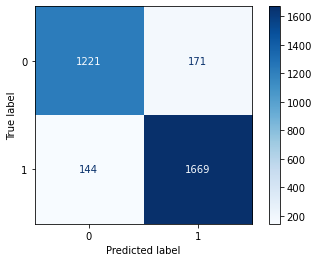

In [26]:
plot_confusion_matrix(rf, X_test_tf, y_test_tf, cmap='Blues', 
                      values_format='d');

### Balance the Data
---

In [27]:
# import libraries
from imblearn.over_sampling import SMOTE
from  imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [28]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(combined['text'],
                                                    combined['subreddit'].values,
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

#### Set up the counter

In [29]:
from collections import Counter

In [30]:
Counter(y_train)

Counter({0: 5618, 1: 7198})

#### Vectorize X

In [31]:
# Vectorize X_train

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

X_train_tf = vectorizer.transform(X_train)
X_train_tf = X_train_tf.toarray()

In [32]:
# Vectorize X_test

X_test_tf = vectorizer.transform(X_test)
X_test_tf = X_test_tf.toarray()

#### Test different sampler with the base model

In [33]:
s = 42

In [34]:
samplers = {"RandomUnderSampler": RandomUnderSampler(random_state=s),
            "SMOTE": SMOTE(random_state=s),
            "SMOTETomek": SMOTETomek(random_state=s)
         }

In [35]:
for name, sampler in samplers.items():
    X_train_s, y_train_s = sampler.fit_resample(X_train_tf, y_train)
    counter = Counter(y_train_s)
    rf.fit(X_train_s, y_train_s)
    rf_pred_s = rf.predict(X_test_tf)
    accuracy = accuracy_score(y_test, rf_pred_s)
    rmse = mse(y_test, rf_pred_s, squared=False)
    f1 = f1_score(y_test, rf_pred_s)
    print(f"{name}\n\
    {counter}\n\
    accuracy_score: {accuracy}\n\
    rmse: {rmse}\n\
    f1_score: {f1}\n")

RandomUnderSampler
    Counter({0: 5618, 1: 5618})
    accuracy_score: 0.8929797191887675
    rmse: 0.3271395433316377
    f1_score: 0.9028603794958935

SMOTE
    Counter({0: 7198, 1: 7198})
    accuracy_score: 0.8967238689547582
    rmse: 0.321366039035306
    f1_score: 0.9075160659402067

SMOTETomek
    Counter({0: 7165, 1: 7165})
    accuracy_score: 0.9051482059282371
    rmse: 0.30798018454401066
    f1_score: 0.9150363331470096



**Conclusion**:<br>
All three samplers produce very similar outcomes.<br>
However, SMOTETomek gives the best accuracy and F1 score with lowest RMSE.
Hence, we will use SMOTETomek.

### Balance the data with SMOTETomek
---

In [36]:
X_train_s, y_train_s = samplers['SMOTETomek'].fit_resample(X_train_tf, y_train)
Counter(y_train_s)

Counter({0: 7165, 1: 7165})

### Comparison with Random Forest
---

In [37]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
import xgboost as xgb

In [38]:
models = {"LogisticRegression": LogisticRegression(random_state=s),
          "Random Forest": RandomForestClassifier(random_state=s),
          "Bagging": BaggingClassifier(random_state=s),
          "XGBoost": xgb.XGBClassifier(seed=s)
         }

In [39]:
for key, model in models.items():
    model.fit(X_train_s, y_train_s)
    train_score = model.score(X_train_s, y_train_s)
    test_score = model.score(X_test_tf, y_test)
    print(f"{key} Train Set Accuracy: {train_score} \n\
    {key} Test Set Accuracy: {test_score} \n")

LogisticRegression Train Set Accuracy: 0.9468946266573621 
    LogisticRegression Test Set Accuracy: 0.9051482059282371 

Random Forest Train Set Accuracy: 0.9997208653175157 
    Random Forest Test Set Accuracy: 0.9051482059282371 

Bagging Train Set Accuracy: 0.9908583391486392 
    Bagging Test Set Accuracy: 0.88798751950078 

XGBoost Train Set Accuracy: 0.9729937194696441 
    XGBoost Test Set Accuracy: 0.9110764430577223 



There is overfitting for all models.
Some tuning is needed to reduce the overfitting.

#### Confusion Matrix

In [40]:
def plot_cm(m):
    
    y_pred_test = m.predict(X_test_tf)
    
    confusion_matrix(y_test, 
                 y_pred_test)
    
    plot_confusion_matrix(m, X_test_tf, y_test, cmap='Blues', 
                      values_format='d', display_labels=['keto', 'inter'])

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


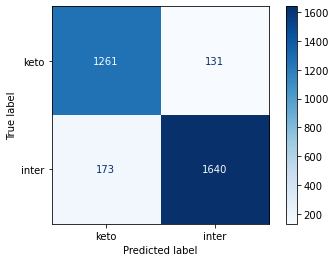

In [41]:
plot_cm(models['LogisticRegression'])

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


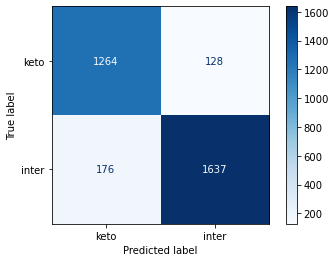

In [42]:
plot_cm(models['Random Forest'])

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


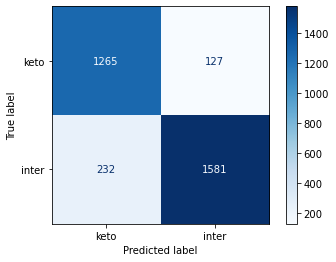

In [43]:
plot_cm(models['Bagging'])

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


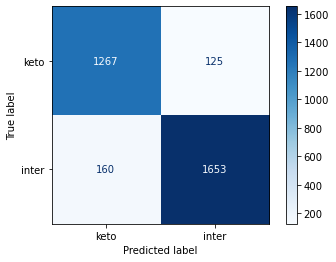

In [44]:
plot_cm(models['XGBoost'])

XGBoost has the lowest Type 1 error although the accuracy score is the second lowest.

#### F1 Score

In [45]:
def f1(m):
    
    y_pred_test = m.predict(X_test_tf)
    
    f1score = f1_score(y_test, y_pred_test)
    
    return f1score

In [46]:
f1(models['LogisticRegression'])

0.9151785714285714

In [47]:
f1(models['Random Forest'])

0.9150363331470096

In [48]:
f1(models['Bagging'])

0.8980403294518603

In [49]:
f1(models['XGBoost'])

0.9206349206349206

### Tune the model
---

In [50]:
md=7
ca=0.05
be=DecisionTreeClassifier(max_depth=md, ccp_alpha=ca)

In [51]:
models1 = {"LogisticRegression": LogisticRegression(C=0.45, random_state=s),
          "Random Forest": RandomForestClassifier(max_depth=md, ccp_alpha=ca, random_state=s),
          "Bagging": BaggingClassifier(base_estimator=be, random_state=s),
          "XGBoost": xgb.XGBClassifier(gamma=1, eta=0.05, max_depth=md, seed=s)
         }

In [52]:
for key, model in models1.items():
    model.fit(X_train_s, y_train_s)
    train_score = model.score(X_train_s, y_train_s)
    test_score = model.score(X_test_tf, y_test)
    print(f"{key} Train Set Accuracy: {train_score} \n\
    {key} Test Set Accuracy: {test_score} \n")

LogisticRegression Train Set Accuracy: 0.9349616189811584 
    LogisticRegression Test Set Accuracy: 0.9060842433697348 

Random Forest Train Set Accuracy: 0.656943475226797 
    Random Forest Test Set Accuracy: 0.6820592823712949 

Bagging Train Set Accuracy: 0.8258199581297976 
    Bagging Test Set Accuracy: 0.8118564742589703 

XGBoost Train Set Accuracy: 0.9376831821353803 
    XGBoost Test Set Accuracy: 0.899219968798752 



#### Confusion Matrix

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


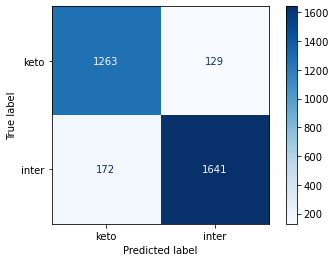

In [53]:
plot_cm(models1['LogisticRegression'])

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


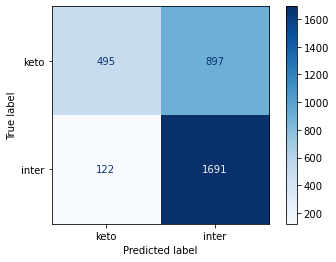

In [54]:
plot_cm(models1['Random Forest'])

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


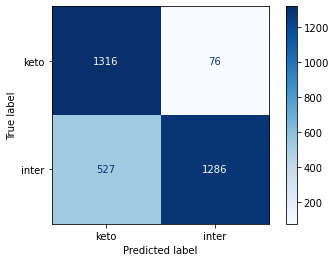

In [55]:
plot_cm(models1['Bagging'])

C:\Users\ng_li\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


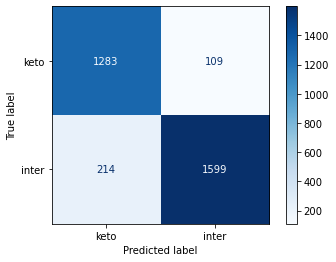

In [56]:
plot_cm(models1['XGBoost'])

#### F1 Score

In [57]:
f1(models1['LogisticRegression'])

0.9159921853195646

In [58]:
f1(models1['Random Forest'])

0.7684617132469893

In [59]:
f1(models1['Bagging'])

0.8100787401574803

In [60]:
f1(models1['XGBoost'])

0.9082646975291111

### Conclusion
---

- The final Bagging model is the only model that meets all of our acceptance criteria.
- Although the accuracy score and the F1 score is the second lowest, it has the smallest overfit value of 1 basis point which can be overlooked.

### Recommendations
---

- We recommend to use Bagging with the below parameters to sort the data between "Intermittentfasting" and "Keto".
    - base_estimator = DecisionTreeClassifier(max_depth=7, ccp_alpha=0.05)
- From the earlier data analysis, it is found that there are many posts by new keto dieters seeking for advices.
- These posts provide valuable insights to us when marketing and producing our new keto meal plan.
- From these posts, we would be able to learn about the common challenges that the new keto dieters and introduce solutions to these challenges, thereby increase takeup rates for our new keto meal plan.
- We could also explore placing ads targeted at these new keto dieters, to help them have an easier dieting journey.